In [83]:
import numpy as np
import torch
from d2l import torch as d2l
import math
from torch import nn

poly_feature是下面这个函数：n=20 $f(x) = \sum_{i=0}^{n} \frac{x^n}{n!}$

In [70]:
max_degree = 20
features = np.random.normal(size=(200, 20))
n_train = 100
n_test = 100
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree))
true_w = np.zeros(max_degree)
true_w[0:4] = [5, 1.2, 3.4, 5.6]
for i in range(max_degree):
    # gamma是阶乘函数
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w) 
labels += np.random.normal(scale=0.1, size=labels.shape)

In [71]:
# true_w, features, poly_features, labels = [x.clone().detach().requires_grad_(True) for x in [true_w, features, poly_features, labels]]
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [72]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [80]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e1],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[5.000842  1.198555  3.4006758 5.6004558]]


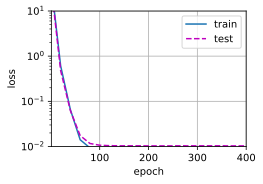

In [77]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[6.7972813 1.2236137]]


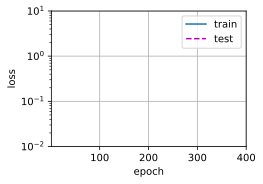

In [78]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.0003181e+00  1.1995416e+00  3.3941834e+00  5.5998759e+00
  -1.8547081e-03 -1.2995689e-01  1.3222717e-01  2.4930380e-02
   1.7581537e-01  2.8484933e-02  1.7095731e-01  6.4648867e-02
  -1.2114432e-01  1.1149119e-01 -1.6378492e-02 -5.7538480e-02
  -9.4536802e-04 -8.6665235e-02  3.1386197e-02 -8.4414937e-02]]


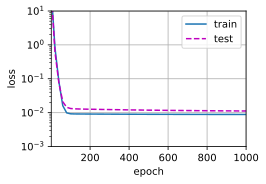

In [82]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1000)